In [108]:
%matplotlib inline

In [109]:
#import sys
#!{sys.executable} -m pip install pomegranate

In [110]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import *
import os
import math
from IPython.display import HTML
from IPython.display import Video

from scipy.signal import deconvolve
import pomegranate
from pomegranate import *

import json


In [218]:
bursts = pd.read_csv('data/Berrocal_particles_analysis.csv')
#bursts = bursts[['nucleus_id', 'particle_id', 'set_id', 'ap_raw', 'ap_registered',
#       'xPos', 'yPos', 'stripe_id', 'inf_flag', 'time', 'fluo']]
#bursts['fluo'] = bursts['fluo'].fillna(0)
#bursts.to_csv('data/Berrocal_particles_analysis.csv',index=False)

In [112]:
bursts = bursts.sort_values(['particle_id','time'])

In [113]:
data = []

for pid in sorted(list(bursts.particle_id.dropna().unique())):
    for time in sorted(list(bursts.time.unique())):
        data.append([pid,time])
        
bursts_filled = pd.DataFrame(data=data,columns=['particle_id','time'])
bursts_filled = bursts_filled.merge(bursts,on=['particle_id','time'],how='left')
bursts_filled['fluo'] = bursts_filled['fluo'].fillna(0)

In [114]:
bpt = bursts_filled.pivot_table(index=['particle_id'],columns=['time'],values=['fluo'])
bpt.columns = [c[1] for c in bpt.columns]
bpt_times = list(bpt.columns)

In [115]:
bpt['fluo_mean'] = bpt[bpt_times].mean(axis=1)

(array([939., 630., 470., 266., 125.,  42.,  36.,  12.,   4.,   2.]),
 array([2.33326711e+02, 2.37408373e+04, 4.72483480e+04, 7.07558586e+04,
        9.42633692e+04, 1.17770880e+05, 1.41278390e+05, 1.64785901e+05,
        1.88293412e+05, 2.11800922e+05, 2.35308433e+05]),
 <a list of 10 Patch objects>)

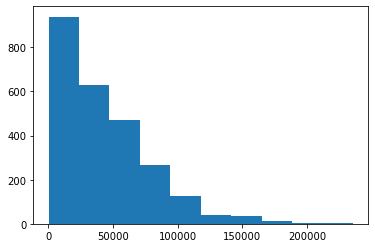

In [116]:
plt.hist(bpt['fluo_mean'])

In [117]:
bpt.columns

Index([          0,          20,          40,          60,          80,
               100,         120,         140,         160,         180,
       ...
              2840,        2860,        2880,        2900,        2920,
              2940,        2960,        2980,        3000, 'fluo_mean'],
      dtype='object', length=152)

In [118]:
test_burst = bpt[bpt_times].loc[1.0163].values

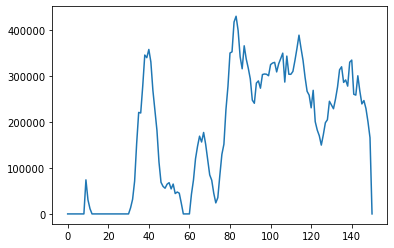

In [119]:
plt.plot(test_burst)

In [120]:
polymerase_transit_time = 7
polymerase_loading_rate = 40000

In [121]:
l = len(test_burst)

basis = np.zeros((l,l))

for i in range(0,l):
    np.put(
        basis[i],
        np.arange(i,min(i+polymerase_transit_time,l)),
        1)

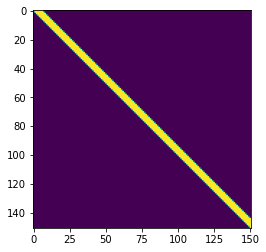

In [122]:
plt.imshow(basis)

In [123]:
test_burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,test_burst)[0] / polymerase_loading_rate,np.ones(5)/5)

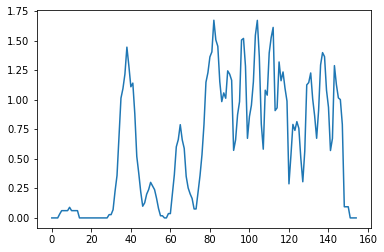

In [124]:
plt.plot(test_burst_nnls)

In [125]:
kon = .1
koff = .1

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

In [126]:
hmm_out = hmm.predict(test_burst_nnls, algorithm='viterbi')[1:]

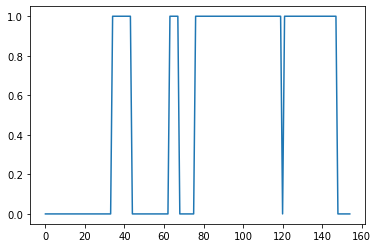

In [127]:
plt.plot(hmm_out)

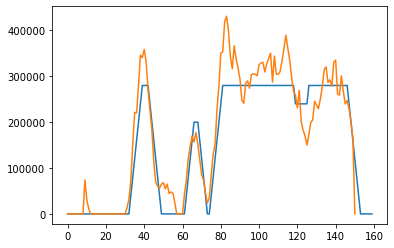

In [128]:
plt.plot(np.convolve(hmm_out[1:],polymerase_loading_rate * np.ones(polymerase_transit_time)))
plt.plot(test_burst)

In [129]:
bursts_to_fit = bpt[bpt.fluo_mean > 50000][bpt_times].values

In [130]:
burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

In [131]:
hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]



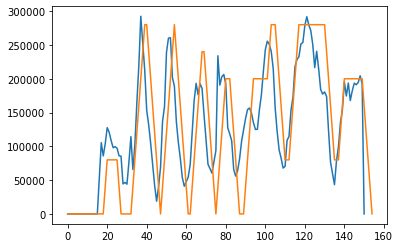

In [132]:
i = 12
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [133]:
hmm_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.9, 0.9, None],
 [0, 1, 0.10000000000000003, 0.1, None],
 [1, 1, 0.9, 0.9, None],
 [1, 0, 0.10000000000000003, 0.1, None]]

In [134]:
hmm_fit = hmm.fit(burst_nnlss,algorithm='viterbi')

In [135]:
hmm_fit_dict = json.loads(hmm.to_json())

In [136]:
hmm_fit_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.9502114875281654, 0.9, None],
 [0, 1, 0.04978851247183461, 0.1, None],
 [1, 1, 0.9735045440159154, 0.9, None],
 [1, 0, 0.02649545598408464, 0.1, None]]

In [137]:
kon_fit = .0497
mean_on = 1/kon_fit
koff_fit = .0264
mean_off = 1/koff_fit
frac_on = mean_on / (mean_on + mean_off)

In [138]:
frac_on * polymerase_transit_time * polymerase_loading_rate

97135.3482260184

In [139]:
np.mean(bursts_to_fit)

81529.17868723182

In [140]:
polymerase_loading_rate = polymerase_loading_rate * np.mean(bursts_to_fit) / (frac_on * polymerase_transit_time * polymerase_loading_rate)

In [141]:
polymerase_loading_rate

33573.43343126808

In [142]:
burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]

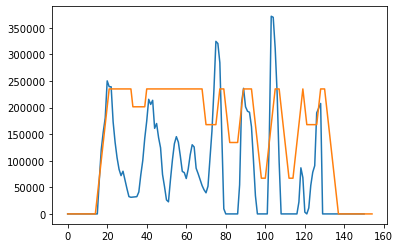

In [143]:
i = 10
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [144]:
kon = .1
koff = .1
polymerase_loading_rate = 33573
polymerase_transit_time = 7

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

In [145]:
hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]    
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]



In [146]:
from itertools import groupby

In [147]:
runlens = [[0],[0]]

for d in hmm_out:
    for i,r in groupby(d):
        runlens[int(i)].append(len(list(r)))
        

Mean Off:  19.89568345323741
Implied kon:  0.05026215874163804


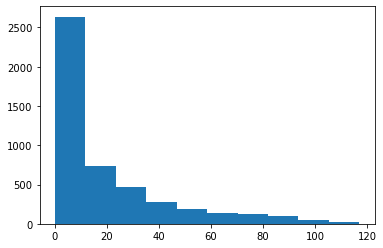

In [148]:
plt.hist(runlens[0])
print ("Mean Off: " , np.mean(runlens[0]))
print ("Implied kon: ", 1/np.mean(runlens[0]))

Mean On:  11.994255874673629
Implied koff:  0.08337324219600331


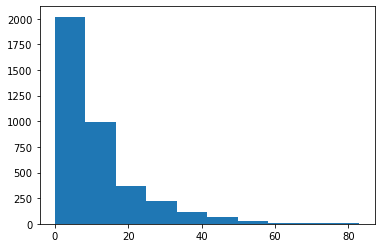

In [149]:
plt.hist(runlens[1])
print ("Mean On: " , np.mean(runlens[1]))
print ("Implied koff: ", 1/np.mean(runlens[1]))

In [150]:
kon = .05
koff = .08
polymerase_loading_rate = 33573
polymerase_transit_time = 7

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]

Mean Off:  19.89568345323741
Implied kon:  0.05026215874163804


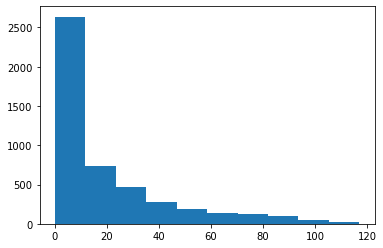

In [151]:
plt.hist(runlens[0])
print ("Mean Off: " , np.mean(runlens[0]))
print ("Implied kon: ", 1/np.mean(runlens[0]))

Mean On:  11.994255874673629
Implied koff:  0.08337324219600331


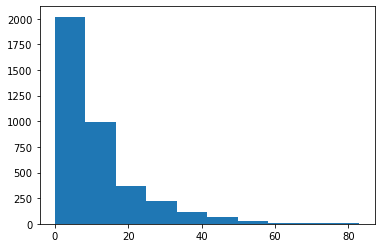

In [152]:
plt.hist(runlens[1])
print ("Mean On: " , np.mean(runlens[1]))
print ("Implied koff: ", 1/np.mean(runlens[1]))

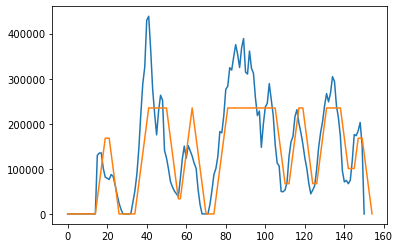

In [153]:
i = 4
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [154]:
kon = .05
koff = .08
polymerase_loading_rate = 33573
polymerase_transit_time = 7

# nnls

burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

# hmm

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]


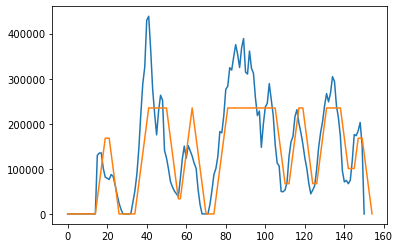

In [155]:
i = 4
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [156]:
polymerase_loading_rate * np.mean(bursts_to_fit) / (frac_on * polymerase_transit_time * polymerase_loading_rate)

33573.43343126808

In [174]:
kon = .05
koff = .08
polymerase_loading_rate = 33000
polymerase_transit_time = 8

l = bursts_to_fit.shape[1]

basis = np.zeros((l,l))

for i in range(0,l):
    np.put(
        basis[i],
        np.arange(i,min(i+polymerase_transit_time,l)),
        1)
    
    
# nnls

burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

# hmm

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]
    
    



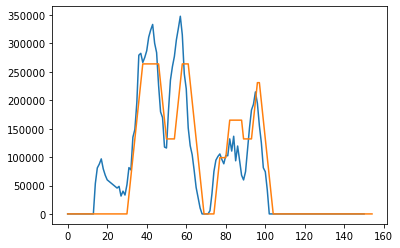

In [175]:
i = 3
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

In [204]:
bursts_to_fit = bpt[bpt_times].values
bursts_to_fit_ids = bpt.index

In [177]:
kon = .05
koff = .08
polymerase_loading_rate = 33000
polymerase_transit_time = 8

l = bursts_to_fit.shape[1]

basis = np.zeros((l,l))

for i in range(0,l):
    np.put(
        basis[i],
        np.arange(i,min(i+polymerase_transit_time,l)),
        1)
    
    
# nnls

burst_nnlss = []

for burst in bursts_to_fit:
    burst_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst)[0] / polymerase_loading_rate,np.ones(5)/5)
    burst_nnlss.append(burst_nnls)
    
burst_nnlss = np.array(burst_nnlss)

# hmm

d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

hmm_out = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))
hmm_pred = np.zeros((burst_nnlss.shape[0],burst_nnlss.shape[1]))

for i, burst in enumerate(burst_nnlss):
    hmm_out[i] = hmm.predict(burst, algorithm='viterbi')[1:]
    hmm_pred[i] = np.convolve(hmm_out[i],polymerase_loading_rate * np.ones(polymerase_transit_time))[0:len(hmm_out[i])]

Mean Off:  19.89568345323741
Implied kon:  0.05026215874163804


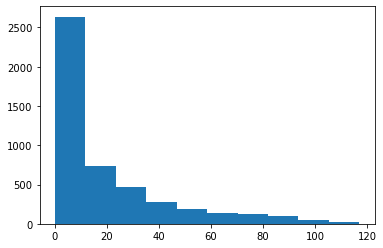

In [178]:
plt.hist(runlens[0])
print ("Mean Off: " , np.mean(runlens[0]))
print ("Implied kon: ", 1/np.mean(runlens[0]))

Mean On:  11.994255874673629
Implied koff:  0.08337324219600331


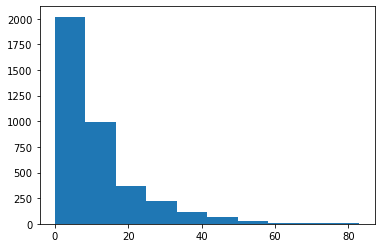

In [179]:
plt.hist(runlens[1])
print ("Mean On: " , np.mean(runlens[1]))
print ("Implied koff: ", 1/np.mean(runlens[1]))

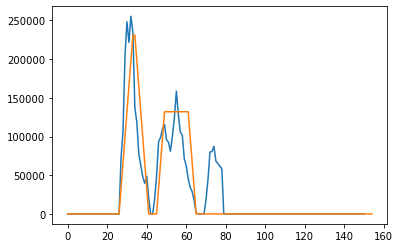

In [182]:
i = 100
plt.plot(bursts_to_fit[i])
plt.plot(hmm_pred[i])

,0,20,40,60,80,100,120,140,160,180,...,2840,2860,2880,2900,2920,2940,2960,2980,3000,fluo_mean
particle_id,,,,,,,,,,,,,,,,,,,,,
1.0163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74245.7306,...,258995.2460,301150.0470,267472.8420,239776.3610,247126.7480,229798.6230,200913.3240,166124.9200,0.0,175264.152436
1.0164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26256.9493,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,56274.174307
1.0166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,6134.379981
1.0167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,102453.116190
1.0168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,78496.559485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.0598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,43292.3040,38390.8531,32834.2505,25762.9146,0.0000,0.0000,0.0000,0.0000,0.0,9925.872838
11.0600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,171419.3690,200036.5750,236360.5790,214088.1430,287176.0610,295473.3550,311125.6050,265477.3120,0.0,29885.376814
11.0601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,116453.5890,101712.9950,108206.8400,104759.9210,93146.7203,89492.7312,78672.7040,0.0000,0.0,9329.797107


In [184]:
bursts

,nucleus_id,particle_id,set_id,ap_raw,ap_registered,xPos,yPos,stripe_id,inf_flag,time,fluo
459,1.0520,1.0163,1,0.287726,0.290066,179.465698,122.691788,1.000000,1.0,180,74245.7306
460,1.0520,1.0163,1,0.285083,0.287585,172.610580,124.755768,1.000000,1.0,200,30713.9331
461,1.0520,1.0163,1,0.284553,0.287095,171.268960,126.067240,1.000000,1.0,220,11364.3210
462,1.0520,1.0163,1,0.286644,0.289101,176.785432,127.000000,1.000000,1.0,240,0.0000
463,1.0520,1.0163,1,0.290501,0.292744,186.893170,127.000000,1.000000,1.0,260,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
335239,9.1587,NaN,9,0.352549,0.367558,427.000000,9.000000,1.666667,NaN,3000,0.0000
335489,9.1600,NaN,9,0.390414,0.406838,526.000000,1.000000,2.333333,NaN,3000,0.0000
336523,9.1647,NaN,9,0.492639,0.498860,784.373896,224.626104,3.333333,NaN,3000,0.0000
336633,9.1653,NaN,9,0.344928,0.352584,401.373896,167.626104,1.666667,NaN,3000,0.0000


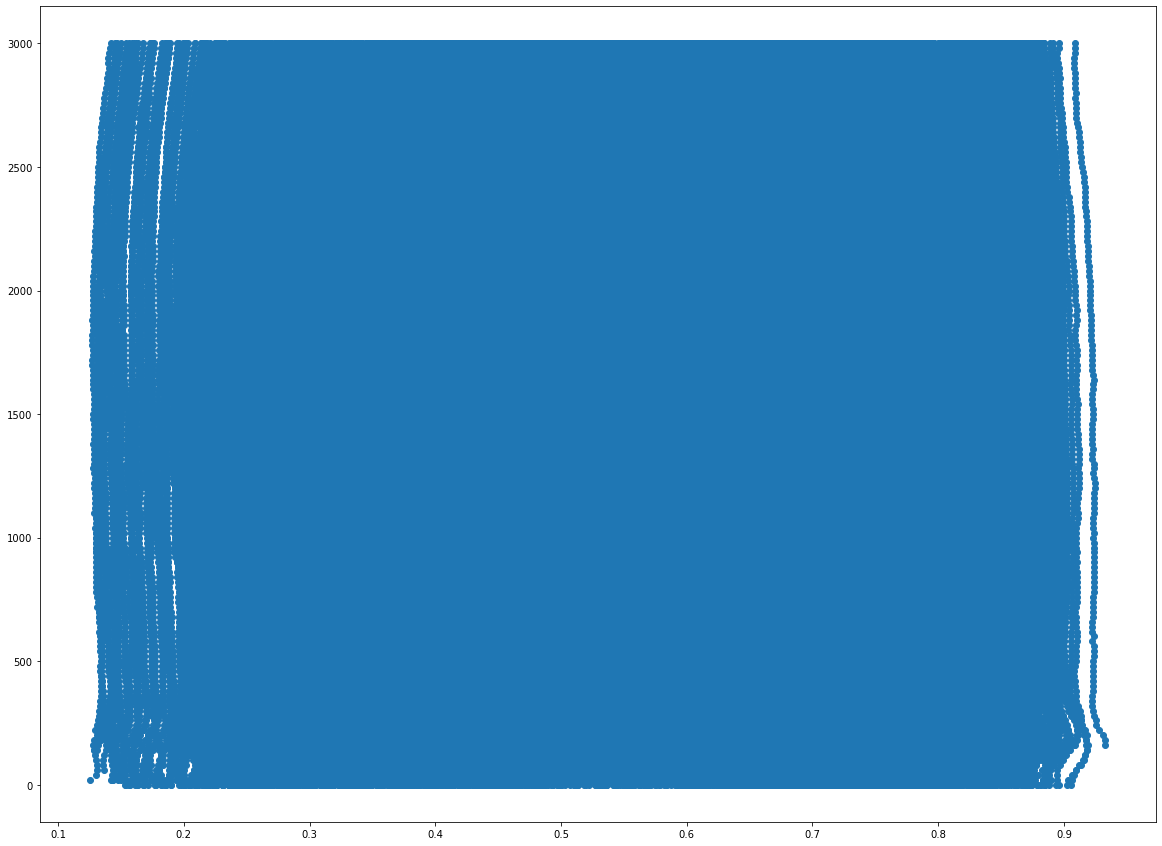

In [203]:
plt.figure(figsize=(20,15))
plt.scatter(bursts.ap_registered,bursts.time)

In [193]:
bursts.fluo / 10000

459       7.424573
460       3.071393
461       1.136432
462       0.000000
463       0.000000
            ...   
335239    0.000000
335489    0.000000
336523    0.000000
336633    0.000000
336742    0.000000
Name: fluo, Length: 430073, dtype: float64

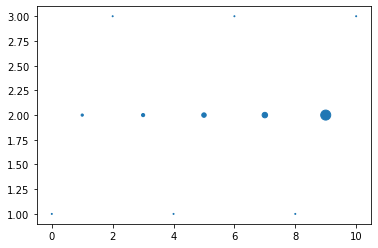

In [201]:
x = [0,1,2,3,4,5,6,7,8,9,10]
y = [1,2,3,2,1,2,3,2,1,2,3]
s = [1,5,1,10,1,20,1,30,1,100.23,1]

plt.scatter(x,y,s=s)

In [261]:
data = []

for i,burst_id in enumerate(bursts_to_fit_ids):
    diff = hmm_out[i][1:] - hmm_out[i][0:-1]
    diff = np.concatenate((np.array([0]),diff))
    ons = np.where(diff == 1,1,0)
    offs = np.where(diff == -1,1,0)
    runlens = [[0],[0]]
    
    interval_len = np.zeros(len(hmm_out[i]))
    p = 0
    for gi,gr in groupby(hmm_out[i]):
        l = len(list(gr))
        interval_len[p] = l
        p += l
        
    
    for j,t in enumerate(bpt_times):
        data.append([burst_id,t,hmm_out[i][j],hmm_pred[i][j],ons[j],offs[j],interval_len[j]])
        
        
hmm_df = pd.DataFrame(data=data,columns=['particle_id','time','promoter_state','fluo_hmm','ons','offs','duration'])

In [263]:
bursts = pd.read_csv('data/Berrocal_particles_analysis.csv')
bursts = bursts.merge(hmm_df,on=['particle_id','time'])

(3000.0, 0.0)

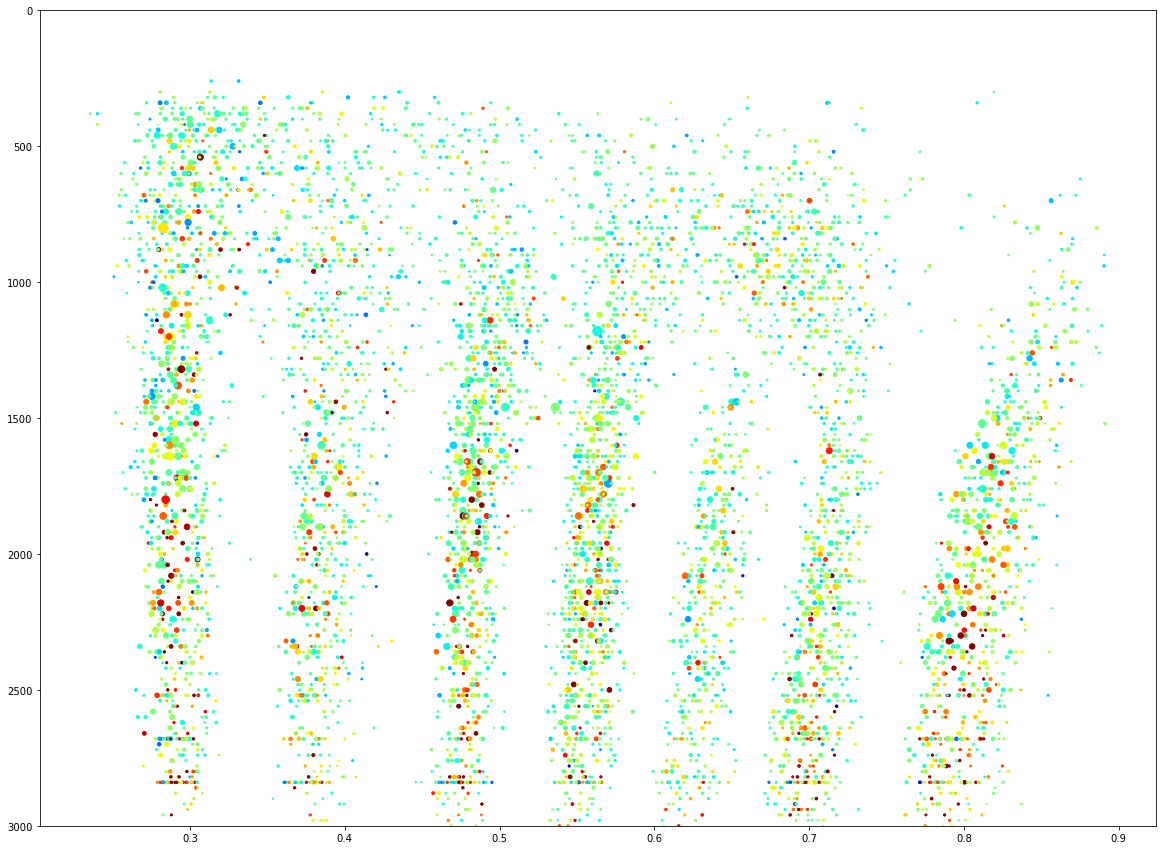

In [264]:
plt.figure(figsize=(20,15))
df = bursts[bursts.ons == 1]
plt.scatter(df.ap_registered,df.time,c=df.fluo,cmap='jet',vmin=0,vmax=200000,s=df.duration)
plt.ylim(3000,0)

(3000.0, 0.0)

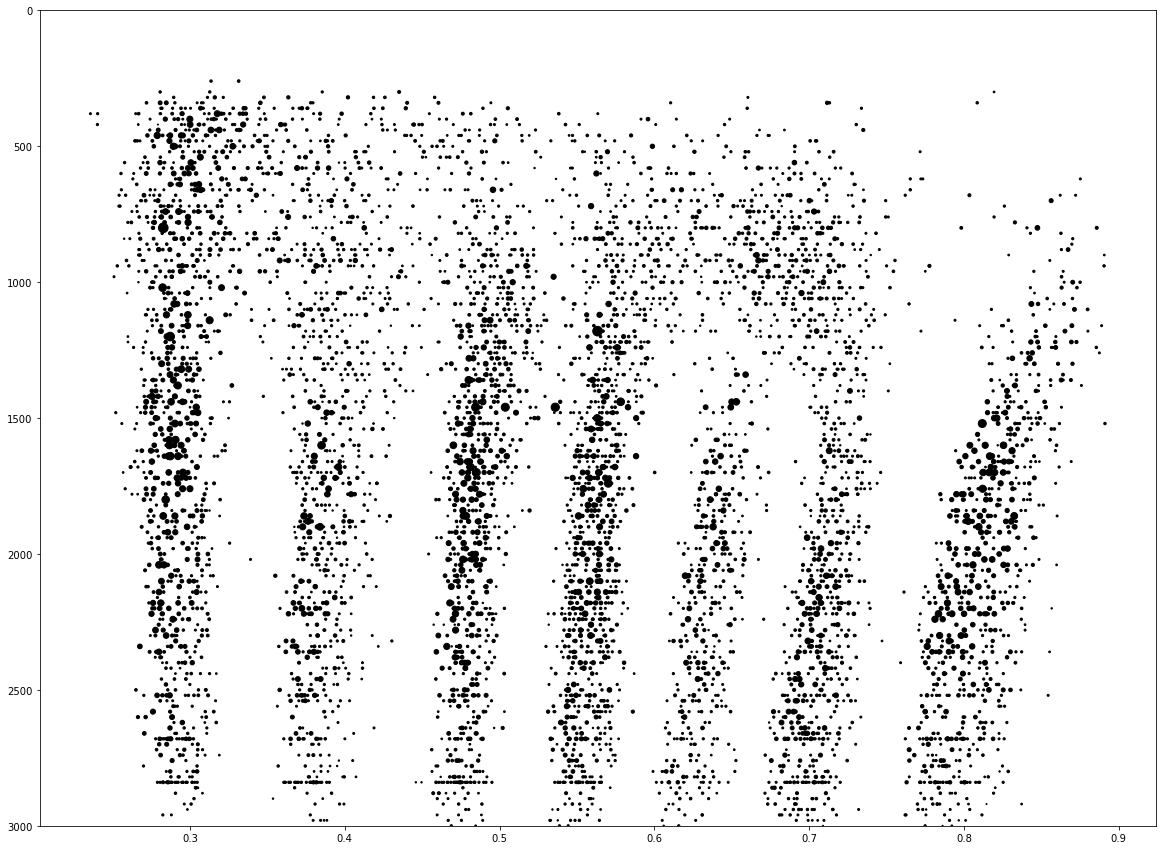

In [265]:
plt.figure(figsize=(20,15))
df = bursts[bursts.ons == 1]
plt.scatter(df.ap_registered,df.time,c='black',s=df.duration)
plt.ylim(3000,0)

In [266]:
from matplotlib.backends.backend_pdf import PdfPages

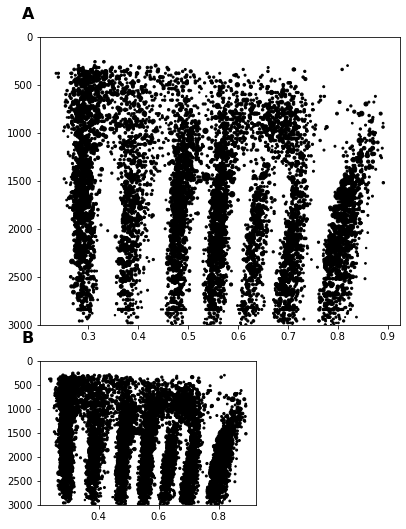

In [284]:
df = bursts[bursts.ons == 1]

pdffile = "Figure.pdf"
with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))
    
    # place panel A centered on page left-to-right and up to 1" margin on top
    panelw = 5
    panelh = 4
    
    margin_top = 1
    
    panelx = (figw - panelw) / 2.0
    panely = figh - margin_top - panelh
    
    ax1 = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    ax1.scatter(df.ap_registered,df.time,c='black',s=df.duration)
    ax1.set_ylim(3000,0)

    labeloffset_x = .25
    labeloffset_y = .25
    
    labelx = panelx - labeloffset_x
    labely = panely + panelh + labeloffset_y
    plt.figtext(labelx/figw,labely/figh,"A", {"fontsize" : 16, "fontweight" : 'bold'})

    
    # place panel A centered on page left-to-right and up to 1" margin on top
    panel2w = 3
    panel2h = 2

    
    panel2x = (figw - panelw) / 2.0
    panel2y = figh - margin_top - panelh - .5 - panel2h
    
    ax2 = fig.add_axes([panel2x/figw,panel2y/figh,panel2w/figw,panel2h/figh])
    ax2.scatter(df.ap_registered,df.time,c='black',s=df.duration)
    ax2.set_ylim(3000,0)

    labeloffset_x = .25
    labeloffset_y = .25
    
    label2x = panel2x - labeloffset_x
    label2y = panel2y + panel2h + labeloffset_y
    plt.figtext(label2x/figw,label2y/figh,"B", {"fontsize" : 16, "fontweight" : 'bold'})
        
    pdf.savefig()

In [ ]:


    plt.figtext(xf[0]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"A", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"B", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[0]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"C", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[1]-labeloffset_x,yf[0]+hf[0]+labeloffset_y,"D", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[1]-labeloffset_x,yf[1]+hf[0]+labeloffset_y,"E", {"fontsize" : 12, "fontweight" : 'bold'})
    plt.figtext(xf[1]-labeloffset_x,yf[2]+hf[0]+labeloffset_y,"F", {"fontsize" : 12, "fontweight" : 'bold'})

